# NYC TLC Data Project
James McCarthy

5/3/2025

## Introduction

Welcome to my data project! In this file, I will be using Python to gain insights into yellow taxi trip record data collected during January 2025. The goals of this analysis are trifold. First, I will compare descriptive statistics on congestion fee revenue, trip duration, and the number of taxi trips entering lower Manhattan before and after the implementation of the MTA Congestion Relief Zone on January 5th, 2025. Second, I will analyze the spatial distribution of demand to understand where yellow taxis are being used. Lastly, I will model the effects of distance, rush hour, and trips located in Manhattan on yellow taxi trip duration. 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import geopandas as gpd #choropleths
import matplotlib.pyplot as plt #graphs
import statsmodels.api as sm #lm
import statsmodels.formula.api as smf #lm with a formula

# print all outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Read In

I decided to analyze the parquet file for Yellow Taxi Trip Records during the month of January 2025. I'm also reading in the Taxi Zone Lookup Table and Taxi Zone Shapefile from the TLC Trip Data Records website.

In [2]:
trip_data = pd.read_parquet('C:/Users/jmcca/OneDrive/Documents/Data/yellow_tripdata_2025-01.parquet', engine='pyarrow')
location_ids = pd.read_csv('C:/Users/jmcca/OneDrive/Documents/Data/taxi_zone_lookup.csv')
nyc_shape = gpd.read_file('C:/Users/jmcca/OneDrive/Documents/Data/taxi_zones.shp')

## Quality Checking

In this section, I will quality check the data to better understand it and look for any potential validation issues

In [3]:
# describe the trip data by each column
trip_data.head() #print head of trips data
trip_data.dtypes # data types
trip_data.shape # number of rows and columns
trip_data.describe() # descriptive stats of trips_data
# min dropoff time being before min pickup time is suspicicous - check instances where dropoff < pickup
# also some Dec 2024 and Feb 2025 values in pickup/dropoff - count how many instances
# some passenger counts are 0 - investigate
# max trip_distance looks unbelievable - check large values, and 0 values
# location IDs of 265 will have to be converted to missing
# fare_amount - investigate negative and very large fares
# extra, mta_tax, improvement_surcharge, congestion_surcharge, airport_fee, cbd_congestion_fee - investigate negatives
# tip_amount, tolls_amount - investigate negative and large values
# total_amount - check that negatives and if all fares/taxes/tips add up

# check the object column store_and_fwd_flag
trip_data['store_and_fwd_flag'].unique()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0


VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
cbd_congestion_fee              float64
dtype: object

(3475226, 20)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
count,3.475226e+06,3475226,3475226,2.935077e+06,3.475226e+06,2.935077e+06,3.475226e+06,3.475226e+06,3.475226e+06,3.475226e+06,3.475226e+06,3.475226e+06,3.475226e+06,3.475226e+06,3.475226e+06,3.475226e+06,2.935077e+06,2.935077e+06,3.475226e+06
mean,1.785428e+00,2025-01-17 11:02:55.910964,2025-01-17 11:17:56.997901,1.297859e+00,5.855126e+00,2.482535e+00,1.651916e+02,1.641252e+02,1.036623e+00,1.708180e+01,1.317737e+00,4.780991e-01,2.959813e+00,4.493081e-01,9.547946e-01,2.561129e+01,2.225237e+00,1.239111e-01,4.834093e-01
min,1.000000e+00,2024-12-31 20:47:55,2024-12-18 07:52:40,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-9.000000e+02,-7.500000e+00,-5.000000e-01,-8.600000e+01,-1.269400e+02,-1.000000e+00,-9.010000e+02,-2.500000e+00,-1.750000e+00,-7.500000e-01
25%,2.000000e+00,2025-01-10 07:59:01,2025-01-10 08:15:29.500000,1.000000e+00,9.800000e-01,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.520000e+01,2.500000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,2025-01-17 15:41:33,2025-01-17 15:59:34,1.000000e+00,1.670000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.211000e+01,0.000000e+00,5.000000e-01,2.450000e+00,0.000000e+00,1.000000e+00,1.995000e+01,2.500000e+00,0.000000e+00,7.500000e-01
75%,2.000000e+00,2025-01-24 19:34:06,2025-01-24 19:48:31,1.000000e+00,3.100000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.950000e+01,2.500000e+00,5.000000e-01,3.930000e+00,0.000000e+00,1.000000e+00,2.778000e+01,2.500000e+00,0.000000e+00,7.500000e-01
max,7.000000e+00,2025-02-01 00:00:44,2025-02-01 23:44:11,9.000000e+00,2.764236e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,8.633721e+05,1.500000e+01,1.050000e+01,4.000000e+02,1.709400e+02,1.000000e+00,8.633804e+05,2.500000e+00,6.750000e+00,7.500000e-01
std,4.263282e-01,NaN,NaN,7.507503e-01,5.646016e+02,1.163277e+01,6.452948e+01,6.940169e+01,7.013334e-01,4.634729e+02,1.861509e+00,1.374623e-01,3.779681e+00,2.002582e+00,2.781938e-01,4.636585e+02,9.039932e-01,4.725090e-01,3.619307e-01


array(['N', 'Y', None], dtype=object)

In [4]:
# get missing counts 
trip_data.isna().sum()
# about half a million observations have no passengers, rate code, congestion surcharge, or airport fee
# I wanted to investigate if these are all the same observations, and if they look like real trips

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          540149
trip_distance                 0
RatecodeID               540149
store_and_fwd_flag       540149
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     540149
Airport_fee              540149
cbd_congestion_fee            0
dtype: int64

In [5]:
# filter for passenger_count column being missing
trip_data_missing = trip_data[trip_data['passenger_count'].isna()]

# check shape
trip_data_missing.shape
# 540,149 rows

# count missings again
trip_data_missing.isna().sum()
# missingness counts match full dataset, so whenever passenger_count is missing, so is RatecodeID, store_and_fwd_flag, congestion_surcharg, and Airport_fee

(540149, 20)

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          540149
trip_distance                 0
RatecodeID               540149
store_and_fwd_flag       540149
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     540149
Airport_fee              540149
cbd_congestion_fee            0
dtype: int64

In [6]:
# are there any other reasons why all these rows have these missing values?
trip_data_missing.describe()
# all missing data seems to be associated with flex fare payemnts (payment_type = 0), is it 1:1?

trip_data.groupby('payment_type').agg(count = ('payment_type', 'count'))
#yes Ns match, what is a flex fare?
# ahh these appear to be when people hail a cab and pay upfront like through curb
# this makes sense for why those specific columns have missings

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
count,540149.000000,540149,540149,0.0,540149.000000,0.0,540149.000000,540149.000000,540149.0,540149.000000,540149.000000,540149.000000,540149.000000,540149.000000,540149.000000,540149.000000,0.0,0.0,540149.000000
mean,1.840326,2025-01-19 11:25:23.960768,2025-01-19 11:40:45.437421,NaN,20.314573,NaN,156.433867,154.447876,0.0,14.587529,0.040605,0.499462,0.452353,0.176154,0.998552,20.085374,NaN,NaN,0.537799
min,1.000000,2025-01-01 00:00:00,2025-01-01 00:00:00,NaN,0.000000,NaN,2.000000,1.000000,0.0,-41.450000,-3.250000,-0.500000,-4.740000,0.000000,-1.000000,-33.820000,NaN,NaN,-0.750000
25%,2.000000,2025-01-13 23:44:22,2025-01-13 23:57:12,NaN,1.130000,NaN,97.000000,90.000000,0.0,8.370000,0.000000,0.500000,0.000000,0.000000,1.000000,12.810000,NaN,NaN,0.000000
50%,2.000000,2025-01-19 21:41:54,2025-01-19 21:53:52,NaN,2.040000,NaN,158.000000,158.000000,0.0,14.040000,0.000000,0.500000,0.000000,0.000000,1.000000,18.810000,NaN,NaN,0.750000
75%,2.000000,2025-01-25 06:59:56,2025-01-25 07:17:40,NaN,3.610000,NaN,232.000000,231.000000,0.0,20.920000,0.000000,0.500000,0.000000,0.000000,1.000000,25.740000,NaN,NaN,0.750000
max,6.000000,2025-01-31 23:59:59,2025-02-01 03:14:40,NaN,276423.570000,NaN,265.000000,265.000000,0.0,503.590000,11.750000,10.500000,40.000000,51.380000,1.000000,531.900000,NaN,NaN,0.750000
std,0.390237,NaN,NaN,NaN,1428.575951,NaN,71.812144,71.389869,0.0,12.658203,0.392665,0.036850,1.676302,1.178284,0.035985,12.993654,NaN,NaN,0.337828


,count
payment_type,
0,540149
1,2444393
2,390429
3,23773
4,76481
5,1


In [7]:
# time checks
trip_data[trip_data['tpep_pickup_datetime'] > trip_data['tpep_dropoff_datetime']]
# 124 rows where pickup time is after dropoff time, which will have to be adjusted for a duration measure

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
99620,1,2025-01-02 12:26:00,2025-01-02 11:29:58,1.0,9.00,99.0,N,88,210,1,45.5,0.0,0.5,0.0,0.00,0.0,46.00,0.0,0.0,0.0
459885,1,2025-01-06 16:00:00,2025-01-06 15:05:30,1.0,3.80,99.0,N,208,254,1,24.5,0.0,0.5,0.0,0.00,0.0,25.00,0.0,0.0,0.0
1315880,1,2025-01-15 15:00:00,2025-01-15 14:42:48,1.0,1.00,99.0,N,107,4,1,18.5,0.0,0.5,0.0,0.00,0.0,19.00,0.0,0.0,0.0
2029534,1,2025-01-23 01:44:59,2024-12-18 07:52:40,0.0,3.10,1.0,N,162,238,1,21.9,2.5,0.5,4.5,0.00,1.0,30.40,2.5,0.0,0.0
2058555,1,2025-01-23 12:30:00,2025-01-23 11:44:59,1.0,3.90,99.0,N,236,116,1,27.5,0.0,0.5,0.0,0.00,0.0,28.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419203,6,2025-01-29 22:01:23,2025-01-29 22:01:13,NaN,4.92,NaN,None,61,76,0,2.9,0.0,0.5,0.0,0.00,0.3,22.64,NaN,NaN,0.0
3424926,6,2025-01-30 08:01:40,2025-01-30 08:01:09,NaN,13.77,NaN,None,146,175,0,2.9,0.0,0.5,0.0,0.00,0.3,44.72,NaN,NaN,0.0
3430705,6,2025-01-30 16:01:38,2025-01-30 16:01:31,NaN,5.18,NaN,None,142,42,0,2.9,0.0,0.5,0.0,0.00,0.3,27.81,NaN,NaN,0.0
3443840,6,2025-01-30 23:01:38,2025-01-30 23:01:26,NaN,7.30,NaN,None,183,119,0,2.9,0.0,0.5,0.0,0.00,0.3,24.20,NaN,NaN,0.0


In [8]:
# check if there are pickups outside of january
early_pickups = trip_data[trip_data['tpep_pickup_datetime'] < pd.to_datetime('2025-01-01')]
early_pickups
early_pickups.shape
# 21 pickups in Dec 24

late_pickups = trip_data[trip_data['tpep_pickup_datetime'] > pd.to_datetime('2025-02-01')]
late_pickups
late_pickups.shape
# 1 pick up in Feb 25

#JM decision: limit the analysis data to pickups within January 2025

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
605,2,2024-12-31 23:30:03,2024-12-31 23:43:02,1.0,3.00,1.0,N,246,13,1,16.3,1.0,0.5,5.32,0.0,1.0,26.62,2.5,0.00,0.0
687,2,2024-12-31 23:31:38,2024-12-31 23:41:48,1.0,1.03,1.0,N,43,140,2,10.7,1.0,0.5,0.00,0.0,1.0,15.70,2.5,0.00,0.0
688,2,2024-12-31 23:46:38,2025-01-01 00:03:03,1.0,3.95,1.0,N,229,24,2,19.1,1.0,0.5,0.00,0.0,1.0,24.10,2.5,0.00,0.0
861,2,2024-12-31 23:56:19,2025-01-01 00:11:19,6.0,2.28,1.0,N,68,107,1,14.9,1.0,0.5,3.98,0.0,1.0,23.88,2.5,0.00,0.0
1108,2,2024-12-31 23:55:37,2025-01-01 00:01:26,1.0,1.12,1.0,N,56,56,2,7.9,1.0,0.5,0.00,0.0,1.0,10.40,0.0,0.00,0.0
1312,2,2024-12-31 23:52:40,2025-01-01 00:23:03,1.0,6.72,1.0,N,114,151,1,34.5,1.0,0.5,7.90,0.0,1.0,47.40,2.5,0.00,0.0
2276,2,2024-12-31 23:49:24,2024-12-31 23:57:30,1.0,2.44,1.0,N,142,151,1,12.1,1.0,0.5,3.42,0.0,1.0,20.52,2.5,0.00,0.0
3941,2,2024-12-31 23:27:13,2024-12-31 23:35:48,1.0,1.53,1.0,N,170,141,1,10.0,1.0,0.5,3.00,0.0,1.0,18.00,2.5,0.00,0.0
3942,2,2024-12-31 23:37:42,2024-12-31 23:43:10,1.0,0.92,1.0,N,229,141,1,7.2,1.0,0.5,1.83,0.0,1.0,14.03,2.5,0.00,0.0
4324,2,2024-12-31 23:51:20,2025-01-01 00:00:00,1.0,12.89,1.0,N,138,40,1,48.5,6.0,0.5,11.55,0.0,1.0,69.30,0.0,1.75,0.0


(21, 20)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
2931841,2,2025-02-01 00:00:44,2025-02-01 00:05:24,1.0,1.04,1.0,N,113,107,1,6.5,1.0,0.5,9.88,0.0,1.0,22.13,2.5,0.0,0.75


(1, 20)

In [9]:
# dropoffs outside of january
early_dropoffs = trip_data[trip_data['tpep_dropoff_datetime'] < pd.to_datetime('2025-01-01')]
early_dropoffs
early_dropoffs.shape
# Dec 24 dropps generally correlated with Dec 24 pickups, except for one very odd Dec 18th dropoff

late_dropoffs = trip_data[trip_data['tpep_dropoff_datetime'] > pd.to_datetime('2025-02-01')]
late_dropoffs
late_dropoffs.shape
# 1781 dropoffs in Feb 25, though some of them seem to make sense for pick ups late on Jan 31

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
605,2,2024-12-31 23:30:03,2024-12-31 23:43:02,1.0,3.00,1.0,N,246,13,1,16.3,1.0,0.5,5.32,0.0,1.0,26.62,2.5,0.00,0.0
687,2,2024-12-31 23:31:38,2024-12-31 23:41:48,1.0,1.03,1.0,N,43,140,2,10.7,1.0,0.5,0.00,0.0,1.0,15.70,2.5,0.00,0.0
2276,2,2024-12-31 23:49:24,2024-12-31 23:57:30,1.0,2.44,1.0,N,142,151,1,12.1,1.0,0.5,3.42,0.0,1.0,20.52,2.5,0.00,0.0
3941,2,2024-12-31 23:27:13,2024-12-31 23:35:48,1.0,1.53,1.0,N,170,141,1,10.0,1.0,0.5,3.00,0.0,1.0,18.00,2.5,0.00,0.0
3942,2,2024-12-31 23:37:42,2024-12-31 23:43:10,1.0,0.92,1.0,N,229,141,1,7.2,1.0,0.5,1.83,0.0,1.0,14.03,2.5,0.00,0.0
4654,2,2024-12-31 23:24:31,2024-12-31 23:25:35,5.0,0.28,1.0,N,132,132,2,3.7,1.0,0.5,0.00,0.0,1.0,7.95,0.0,1.75,0.0
5217,2,2024-12-31 23:48:48,2024-12-31 23:55:13,1.0,0.99,1.0,N,114,148,1,7.9,1.0,0.5,3.00,0.0,1.0,15.90,2.5,0.00,0.0
7623,2,2024-12-31 20:47:55,2024-12-31 20:54:00,2.0,1.72,1.0,N,48,246,1,9.3,1.0,0.5,2.86,0.0,1.0,17.16,2.5,0.00,0.0
7624,2,2024-12-31 20:54:50,2024-12-31 21:30:18,2.0,1.39,1.0,N,246,48,1,28.2,1.0,0.5,6.64,0.0,1.0,39.84,2.5,0.00,0.0
7625,2,2024-12-31 21:20:05,2024-12-31 21:35:13,2.0,2.64,1.0,N,42,238,1,16.3,1.0,0.5,2.00,0.0,1.0,23.30,2.5,0.00,0.0


(14, 20)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
2853317,2,2025-01-31 09:08:29,2025-02-01 08:20:39,1.0,3.86,1.0,N,79,88,1,19.10,0.0,0.5,4.77,0.0,1.0,28.62,2.5,0.00,0.75
2857182,2,2025-01-31 11:13:51,2025-02-01 10:05:49,1.0,3.52,1.0,N,238,170,2,26.10,0.0,0.5,0.00,0.0,1.0,30.85,2.5,0.00,0.75
2863185,2,2025-01-31 12:21:33,2025-02-01 11:47:19,1.0,3.01,1.0,N,234,43,1,21.20,0.0,0.5,5.19,0.0,1.0,31.14,2.5,0.00,0.75
2868652,2,2025-01-31 13:37:18,2025-02-01 12:54:41,1.0,2.76,1.0,N,140,74,1,17.00,0.0,0.5,0.80,0.0,1.0,21.80,2.5,0.00,0.00
2874395,2,2025-01-31 14:27:48,2025-02-01 14:21:20,1.0,24.26,1.0,N,138,27,2,93.30,5.0,0.5,0.00,2.6,1.0,104.15,0.0,1.75,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3475208,2,2025-01-31 23:50:58,2025-02-01 00:06:24,NaN,1.56,NaN,None,246,249,0,8.99,0.0,0.5,0.00,0.0,1.0,13.74,NaN,NaN,0.75
3475214,2,2025-01-31 23:52:34,2025-02-01 00:03:35,NaN,3.24,NaN,None,65,80,0,17.34,0.0,0.5,0.00,0.0,1.0,18.84,NaN,NaN,0.00
3475216,2,2025-01-31 23:58:20,2025-02-01 00:04:17,NaN,1.19,NaN,None,142,50,0,7.65,0.0,0.5,0.00,0.0,1.0,12.40,NaN,NaN,0.75
3475222,2,2025-01-31 23:50:29,2025-02-01 00:17:27,NaN,8.73,NaN,None,161,116,0,28.14,0.0,0.5,0.00,0.0,1.0,32.89,NaN,NaN,0.75


(1781, 20)

In [10]:
# investigating passenger count
trip_data.groupby('passenger_count').agg(count = ('passenger_count', 'count'))
# most trips have 1-4 passengers, but some have 0

# investigate if zero passenger trips are real trips
zero_passengers = trip_data[trip_data['passenger_count'] == 0]
zero_passengers.head(10)
# these seem like real trips, maybe this is simply a data collection error and passenger_count should be NA where 0

,count
passenger_count,
0.0,24656
1.0,2322434
2.0,407761
3.0,91409
4.0,59009
5.0,17786
6.0,12004
7.0,4
8.0,11


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
6,1,2025-01-01 00:14:47,2025-01-01 00:16:15,0.0,0.4,1.0,N,170,170,1,4.4,3.5,0.5,2.35,0.0,1.0,11.75,2.5,0.0,0.0
7,1,2025-01-01 00:39:27,2025-01-01 00:51:51,0.0,1.6,1.0,N,234,148,1,12.1,3.5,0.5,2.00,0.0,1.0,19.10,2.5,0.0,0.0
8,1,2025-01-01 00:53:43,2025-01-01 01:13:23,0.0,2.8,1.0,N,148,170,1,19.1,3.5,0.5,3.00,0.0,1.0,27.10,2.5,0.0,0.0
94,1,2025-01-01 00:11:27,2025-01-01 00:16:58,0.0,0.7,1.0,N,144,211,1,7.2,3.5,0.5,0.00,0.0,1.0,12.20,2.5,0.0,0.0
95,1,2025-01-01 00:19:30,2025-01-01 00:27:25,0.0,1.0,1.0,N,211,158,1,9.3,3.5,0.5,2.85,0.0,1.0,17.15,2.5,0.0,0.0
96,1,2025-01-01 00:33:13,2025-01-01 00:40:08,0.0,1.2,1.0,N,158,68,1,8.6,3.5,0.5,1.00,0.0,1.0,14.60,2.5,0.0,0.0
97,1,2025-01-01 00:45:05,2025-01-01 01:20:32,0.0,1.8,1.0,N,68,50,1,28.2,3.5,0.5,8.30,0.0,1.0,41.50,2.5,0.0,0.0
173,1,2025-01-01 00:01:44,2025-01-01 00:08:38,0.0,0.9,1.0,N,113,148,1,7.9,3.5,0.5,1.00,0.0,1.0,13.90,2.5,0.0,0.0
174,1,2025-01-01 00:14:06,2025-01-01 00:32:34,0.0,2.1,1.0,N,148,164,1,14.9,3.5,0.5,5.95,0.0,1.0,25.85,2.5,0.0,0.0
175,1,2025-01-01 00:52:53,2025-01-01 01:01:04,0.0,1.5,1.0,N,249,246,1,9.3,3.5,0.5,3.00,0.0,1.0,17.30,2.5,0.0,0.0


In [11]:
# trip distance checking
# im going to investigate trips that are over 50 miles
# it makes sense that some trips going outside the city can be long
long_trips = trip_data[trip_data['trip_distance'] > 50]
long_trips.shape
# 533 observations over 100 miles
long_trips.describe()
# max trip is 276,423 miles, more than the distance to the moon

# zero length trips
zero_distance = trip_data[trip_data['trip_distance'] == 0] #90,893 rows with 0 distance
zero_distance
zero_distance.describe()
# based on total_amount values, I think these are real trips

#JM decision: I will convert all trip_distance values over 50 miles to NA, since it is a relatively small proportion of the data anyways.
# The 0 distance values look like data errors to me, and I will also convert these to NA

(533, 20)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
count,533.000000,533,533,400.000000,533.000000,400.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,400.000000,400.000000,533.000000
mean,1.874296,2025-01-16 11:52:39.784240,2025-01-16 13:29:05.178236,1.505000,18043.873396,7.355000,142.082552,225.287054,1.138837,214.019944,0.550657,0.234522,17.006942,9.438499,0.888555,243.736323,0.256250,0.905625,0.212477
min,1.000000,2025-01-01 00:46:00,2025-01-01 00:53:00,0.000000,50.160000,1.000000,3.000000,4.000000,0.000000,-826.200000,-5.000000,-0.500000,0.000000,-45.940000,-1.000000,-865.390000,-2.500000,-1.750000,0.000000
25%,2.000000,2025-01-09 02:52:13,2025-01-09 06:05:00,1.000000,55.160000,4.000000,132.000000,224.000000,1.000000,24.330000,0.000000,0.000000,0.000000,0.000000,1.000000,29.350000,0.000000,0.000000,0.000000
50%,2.000000,2025-01-16 14:53:21,2025-01-16 18:05:00,1.000000,65.650000,4.000000,132.000000,265.000000,1.000000,250.800000,0.000000,0.000000,0.000000,6.940000,1.000000,299.080000,0.000000,1.750000,0.000000
75%,2.000000,2025-01-23 15:22:44,2025-01-23 17:10:43,2.000000,133.300000,5.000000,161.000000,265.000000,2.000000,350.000000,0.000000,0.500000,20.000000,16.060000,1.000000,400.690000,0.000000,1.750000,0.750000
max,2.000000,2025-01-31 22:56:50,2025-02-01 00:11:40,6.000000,276423.570000,99.000000,265.000000,265.000000,4.000000,2450.900000,7.750000,0.500000,138.210000,54.060000,1.000000,2506.710000,2.500000,1.750000,0.750000
std,0.331826,NaN,NaN,0.962961,41907.256563,17.509868,56.885625,70.407342,0.990297,242.519765,1.393464,0.262595,29.091200,13.795144,0.429986,259.070451,0.799411,1.006090,0.338269


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
92,1,2025-01-01 00:49:48,2025-01-01 00:49:48,1.0,0.0,1.0,Y,87,264,2,20.06,0.0,0.0,0.00,0.00,0.0,20.06,0.0,0.0,0.00
204,2,2025-01-01 00:37:43,2025-01-01 00:37:53,1.0,0.0,5.0,N,148,148,1,12.00,0.0,0.0,2.00,0.00,1.0,17.50,2.5,0.0,0.00
358,2,2025-01-01 00:57:08,2025-01-01 00:57:16,3.0,0.0,5.0,N,141,141,1,30.00,0.0,0.0,0.00,0.00,1.0,33.50,2.5,0.0,0.00
505,1,2025-01-01 00:27:40,2025-01-01 00:59:30,1.0,0.0,1.0,N,168,76,1,50.50,0.0,0.5,0.00,6.94,1.0,58.94,0.0,0.0,0.00
619,2,2025-01-01 00:56:49,2025-01-01 00:56:54,4.0,0.0,5.0,N,164,164,1,20.00,0.0,0.0,7.05,0.00,1.0,30.55,2.5,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474740,1,2025-01-31 23:17:38,2025-01-31 23:35:58,NaN,0.0,NaN,None,158,148,0,19.03,0.0,0.5,0.00,0.00,1.0,23.78,NaN,NaN,0.75
3475093,2,2025-01-31 23:39:25,2025-01-31 23:42:06,NaN,0.0,NaN,None,162,162,0,4.80,0.0,0.5,0.00,0.00,1.0,8.80,NaN,NaN,0.00
3475097,1,2025-01-31 23:30:42,2025-01-31 23:31:06,NaN,0.0,NaN,None,79,79,0,6.75,0.0,0.5,0.00,0.00,1.0,11.50,NaN,NaN,0.75
3475144,2,2025-01-31 23:44:00,2025-01-31 23:44:00,NaN,0.0,NaN,None,137,137,0,13.80,0.0,0.5,0.00,0.00,1.0,18.55,NaN,NaN,0.75


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
count,90893.000000,90893,90893,38910.000000,90893.0,38910.000000,90893.00000,90893.000000,90893.000000,90893.000000,90893.000000,90893.000000,90893.000000,90893.000000,90893.000000,90893.000000,38910.000000,38910.000000,90893.000000
mean,1.828766,2025-01-19 01:13:28.159902,2025-01-19 01:25:08.721023,1.337934,0.0,9.430558,158.31382,158.250041,0.814177,17.657909,0.331033,0.396202,1.371214,0.227477,0.891081,23.370932,0.986893,0.108834,0.431535
min,1.000000,2025-01-01 00:00:00,2025-01-01 00:00:00,0.000000,0.0,1.000000,1.00000,1.000000,0.000000,-850.000000,-7.500000,-0.500000,-70.000000,-23.000000,-1.000000,-851.000000,-2.500000,-1.750000,-0.750000
25%,2.000000,2025-01-12 07:47:13,2025-01-12 07:48:12,1.000000,0.0,1.000000,112.00000,107.000000,0.000000,3.000000,0.000000,0.500000,0.000000,0.000000,1.000000,8.300000,0.000000,0.000000,0.000000
50%,2.000000,2025-01-18 18:52:30,2025-01-18 19:00:22,1.000000,0.0,1.000000,161.00000,158.000000,0.000000,13.310000,0.000000,0.500000,0.000000,0.000000,1.000000,18.300000,0.000000,0.000000,0.750000
75%,2.000000,2025-01-25 15:43:57,2025-01-25 15:52:01,1.000000,0.0,5.000000,231.00000,231.000000,1.000000,22.730000,0.000000,0.500000,0.000000,0.000000,1.000000,27.720000,2.500000,0.000000,0.750000
max,7.000000,2025-01-31 23:59:45,2025-02-01 00:31:29,8.000000,0.0,99.000000,265.00000,265.000000,5.000000,950.000000,12.500000,4.000000,360.000000,170.940000,1.000000,953.500000,2.500000,1.750000,0.750000
std,0.381071,NaN,NaN,0.853948,0.0,25.325396,68.91779,70.083357,1.180184,31.187945,1.205730,0.249531,4.807170,1.687773,0.441535,33.583801,1.515517,0.546947,0.376004


In [12]:
# checking unique pickup and dropoff location IDs
pickup_ids = trip_data['PULocationID'].unique()
pickup_ids.sort()
pickup_ids

dropoff_ids = trip_data['DOLocationID'].unique()
dropoff_ids.sort()
dropoff_ids
# all look like valid values

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 106, 107,
       108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 18

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98, 100, 101, 102, 105, 106, 107,
       108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 18

In [13]:
# checking fare/tax/charge negatives
charge_data = trip_data[['fare_amount',
                         'extra',
                         'mta_tax',
                         'tip_amount',
                         'tolls_amount',
                         'improvement_surcharge',
                         'total_amount',
                         'congestion_surcharge',
                         'Airport_fee',
                         'cbd_congestion_fee']].copy()

neg_charge_data = charge_data[charge_data.lt(0).any(axis=1)]
neg_charge_data
#~145,000 rows of data have any negative payment information

charge_data['manual_total_amount'] = charge_data[['fare_amount', 
                                                  'extra', 
                                                  'mta_tax', 
                                                  'tip_amount', 
                                                  'tolls_amount', 
                                                  'improvement_surcharge', 
                                                  'congestion_surcharge',
                                                  'Airport_fee', 
                                                  'cbd_congestion_fee']].sum(axis=1)

charge_data['total_amount_diff'] = charge_data['total_amount'] - charge_data['manual_total_amount']
charge_data['total_amount_diff'].describe()
charge_data[charge_data['total_amount_diff'] == 0].shape
# total_amount matches all fare/tax/tip/surcharge data for ~2 million rows
# JM decision: I will choose to trust total_amount instead of dealing with all of its components, where there is more room for error
# there are still some extreme values in total amount I should address though

,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
17,-7.20,-1.0,-0.5,3.66,0.0,-1.0,-8.54,-2.5,0.0,0.00
22,-6.50,-1.0,-0.5,0.00,0.0,-1.0,-11.50,-2.5,0.0,0.00
104,-16.30,-1.0,-0.5,0.00,0.0,-1.0,-21.30,-2.5,0.0,0.00
149,-12.10,-1.0,-0.5,0.00,0.0,-1.0,-17.10,-2.5,0.0,0.00
202,-7.20,-1.0,-0.5,0.00,0.0,-1.0,-12.20,-2.5,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...
3475198,-1.50,0.0,0.5,0.00,0.0,1.0,1.00,NaN,NaN,0.00
3475204,-4.75,0.0,0.5,0.00,0.0,1.0,4.91,NaN,NaN,0.75
3475205,-4.75,0.0,0.5,0.00,0.0,1.0,3.00,NaN,NaN,0.75
3475212,-4.75,0.0,0.5,0.00,0.0,1.0,2.07,NaN,NaN,0.75


count    3.475226e+06
mean    -9.769531e-02
std      1.890768e+00
min     -1.064000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.353000e+01
Name: total_amount_diff, dtype: float64

(2064293, 12)

In [14]:
# total amount range checks
trip_data[trip_data['total_amount'] > 250].describe()
# taxi trips probably shouldn't cost more than $250, but 945 observations above that
# it seems that some trips might be quite long with a high total_amount

trip_data[trip_data['total_amount'] < 0].describe()
# 63,000 negative total_amount trips

#spot checking this clearly wrong value
trip_data[trip_data['total_amount'] == -901]
# fare_amount is -900 for a 0.1 mile trip
# but payment type is no charge

# check if many no charge trips have high payments
trip_data[trip_data['payment_type'] == 3].describe()
# ~24,000 no charge trips, with some only extreme total_amounts

#JM decision: absolute value total_amount, then convert any values greater then 250 to missing

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
count,945.000000,945,945,942.000000,945.000000,942.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.00000,945.0,945.000000,942.000000,942.000000,945.000000
mean,1.869841,2025-01-15 18:17:02.255026,2025-01-15 19:35:41.838095,1.477707,41.202995,4.248408,146.630688,237.503704,1.382011,1219.416825,1.010582,0.153968,30.042836,11.40945,1.0,1264.334720,0.345011,0.958599,0.149206
min,1.000000,2025-01-01 00:05:51,2025-01-01 00:06:29,0.000000,0.000000,1.000000,10.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.00000,1.0,250.050000,0.000000,0.000000,0.000000
25%,2.000000,2025-01-08 10:36:30,2025-01-08 13:51:54,1.000000,28.290000,4.000000,132.000000,265.000000,1.000000,235.400000,0.000000,0.000000,0.000000,0.00000,1.0,273.750000,0.000000,0.000000,0.000000
50%,2.000000,2025-01-15 03:21:10,2025-01-15 03:23:08,1.000000,42.550000,4.000000,132.000000,265.000000,1.000000,270.400000,0.000000,0.000000,15.000000,6.94000,1.0,310.450000,0.000000,1.750000,0.000000
75%,2.000000,2025-01-23 07:12:44,2025-01-23 08:30:45,2.000000,53.630000,5.000000,142.000000,265.000000,2.000000,345.000000,1.000000,0.500000,50.200000,21.00000,1.0,388.010000,0.000000,1.750000,0.000000
max,2.000000,2025-01-31 21:25:07,2025-01-31 22:38:01,6.000000,255.330000,5.000000,265.000000,265.000000,4.000000,863372.120000,9.250000,0.500000,400.000000,126.94000,1.0,863380.370000,2.500000,1.750000,0.750000
std,0.336656,NaN,NaN,0.947636,29.857609,0.930001,53.509425,64.059048,0.781875,28075.899645,1.798001,0.230942,40.815999,13.63248,0.0,28074.670725,0.862719,0.871460,0.299562


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
count,63037.0,63037,63037,59616.000000,63037.000000,59616.000000,63037.000000,63037.000000,63037.000000,63037.000000,63037.000000,63037.000000,63037.000000,63037.000000,63037.000000,63037.000000,59616.000000,59616.00000,63037.000000
mean,2.0,2025-01-15 15:39:30.560194,2025-01-15 15:53:22.839538,1.376594,4.942377,1.258068,158.356933,156.929740,3.206323,-20.967929,-0.950744,-0.426194,0.064126,-0.588928,-0.890255,-26.293916,-2.026302,-0.30561,-0.077966
min,2.0,2025-01-01 00:00:00,2025-01-01 00:00:00,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,-900.000000,-7.500000,-0.500000,-86.000000,-126.940000,-1.000000,-901.000000,-2.500000,-1.75000,-0.750000
25%,2.0,2025-01-07 05:43:51,2025-01-07 05:55:41,1.000000,0.650000,1.000000,132.000000,100.000000,2.000000,-23.300000,-1.000000,-0.500000,0.000000,0.000000,-1.000000,-28.350000,-2.500000,0.00000,0.000000
50%,2.0,2025-01-15 17:48:23,2025-01-15 18:04:58,1.000000,1.420000,1.000000,151.000000,161.000000,4.000000,-12.100000,0.000000,-0.500000,0.000000,0.000000,-1.000000,-16.850000,-2.500000,0.00000,0.000000
75%,2.0,2025-01-23 20:46:48,2025-01-23 20:58:07,2.000000,3.940000,1.000000,229.000000,230.000000,4.000000,-7.200000,0.000000,-0.500000,0.000000,0.000000,-1.000000,-11.650000,-2.500000,0.00000,0.000000
max,2.0,2025-01-31 23:59:51,2025-02-01 00:15:34,6.000000,81231.220000,99.000000,265.000000,265.000000,4.000000,0.000000,0.000000,0.500000,123.340000,20.820000,1.000000,-0.010000,0.000000,0.00000,0.000000
std,0.0,NaN,NaN,0.764056,323.569531,2.244722,61.078054,69.726744,1.124341,26.494902,1.445247,0.241827,1.271748,2.644881,0.453756,28.176254,0.979730,0.66440,0.228903


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
562142,2,2025-01-07 19:12:25,2025-01-07 19:14:04,1.0,0.1,5.0,N,226,226,3,-900.0,0.0,0.0,0.0,0.0,-1.0,-901.0,0.0,0.0,0.0


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
count,23773.000000,23773,23773,23773.000000,23773.000000,23773.000000,23773.00000,23773.000000,23773.0,23773.000000,23773.000000,23773.000000,23773.000000,23773.000000,23773.000000,23773.000000,23773.000000,23773.000000,23773.000000
mean,1.651958,2025-01-16 09:10:01.495057,2025-01-16 09:21:13.340554,1.284693,2.546687,1.336474,160.13019,159.109200,3.0,4.498180,1.158310,0.151054,0.016866,0.093165,0.311951,6.145837,0.626972,0.039393,0.225256
min,1.000000,2025-01-01 00:00:07,2025-01-01 00:05:19,0.000000,0.000000,1.000000,1.00000,1.000000,3.0,-900.000000,-7.500000,-0.500000,-15.950000,-35.060000,-1.000000,-901.000000,-2.500000,-1.750000,-0.750000
25%,1.000000,2025-01-08 14:36:32,2025-01-08 14:48:53,1.000000,0.070000,1.000000,132.00000,113.000000,3.0,-5.100000,0.000000,-0.500000,0.000000,0.000000,-1.000000,-10.250000,0.000000,0.000000,0.000000
50%,2.000000,2025-01-16 10:27:56,2025-01-16 10:43:07,1.000000,0.890000,1.000000,161.00000,161.000000,3.0,3.700000,0.000000,0.500000,0.000000,0.000000,1.000000,9.400000,0.000000,0.000000,0.000000
75%,2.000000,2025-01-24 09:51:36,2025-01-24 10:00:07,1.000000,2.200000,1.000000,230.00000,230.000000,3.0,12.000000,3.250000,0.500000,0.000000,0.000000,1.000000,17.150000,2.500000,0.000000,0.750000
max,7.000000,2025-01-31 23:59:51,2025-02-01 00:31:48,6.000000,81.140000,99.000000,265.00000,265.000000,3.0,900.000000,14.250000,0.500000,20.000000,35.060000,1.000000,901.000000,2.500000,1.750000,0.750000
std,0.510874,NaN,NaN,0.757352,4.588240,3.661628,61.69448,68.010876,0.0,31.378642,2.429766,0.463708,0.473346,2.081796,0.945747,35.288638,2.064474,0.663235,0.406506


In [15]:
# checking location ids quickly
location_ids.head()
location_ids.describe()
location_ids.isna()
location_ids.tail(5)
# only missing location data is for ids 264 (unknown) and 265 (outside of NYC)

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


,LocationID
count,265.000000
mean,133.000000
std,76.643112
min,1.000000
25%,67.000000
50%,133.000000
75%,199.000000
max,265.000000


,LocationID,Borough,Zone,service_zone
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
260,False,False,False,False
261,False,False,False,False
262,False,False,False,False
263,False,False,True,True


,LocationID,Borough,Zone,service_zone
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN
264,265,NaN,Outside of NYC,NaN


# Data Processing

In this section, I will address the data quality issues found in the Data Quality section above. Additionally, I will create measures for my three analyses. I want to note that normally I would check with a supervisor/manager before making important data decisions.

In [16]:
#JM decision: limit the analysis data to pickups within January 2025
trip_data_january = trip_data[(trip_data['tpep_pickup_datetime'] >= pd.to_datetime('2025-01-01')) & 
(trip_data['tpep_pickup_datetime'] < pd.to_datetime('2025-02-01'))]

trip_data_january.describe()
# pickup times look good to me

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
count,3.475204e+06,3475204,3475204,2.935055e+06,3.475204e+06,2.935055e+06,3.475204e+06,3.475204e+06,3.475204e+06,3.475204e+06,3.475204e+06,3.475204e+06,3.475204e+06,3.475204e+06,3.475204e+06,3.475204e+06,2.935055e+06,2.935055e+06,3.475204e+06
mean,1.785427e+00,2025-01-17 11:03:04.165774,2025-01-17 11:18:05.252241,1.297855e+00,5.855141e+00,2.482545e+00,1.651917e+02,1.641255e+02,1.036621e+00,1.708179e+01,1.317738e+00,4.780989e-01,2.959804e+00,4.493109e-01,9.547943e-01,2.561128e+01,2.225239e+00,1.239108e-01,4.834121e-01
min,1.000000e+00,2025-01-01 00:00:00,2024-12-18 07:52:40,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-9.000000e+02,-7.500000e+00,-5.000000e-01,-8.600000e+01,-1.269400e+02,-1.000000e+00,-9.010000e+02,-2.500000e+00,-1.750000e+00,-7.500000e-01
25%,2.000000e+00,2025-01-10 07:59:10.750000,2025-01-10 08:15:43,1.000000e+00,9.800000e-01,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.520000e+01,2.500000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,2025-01-17 15:41:36.500000,2025-01-17 15:59:40,1.000000e+00,1.670000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.211000e+01,0.000000e+00,5.000000e-01,2.450000e+00,0.000000e+00,1.000000e+00,1.995000e+01,2.500000e+00,0.000000e+00,7.500000e-01
75%,2.000000e+00,2025-01-24 19:34:10,2025-01-24 19:48:33.500000,1.000000e+00,3.100000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.950000e+01,2.500000e+00,5.000000e-01,3.930000e+00,0.000000e+00,1.000000e+00,2.778000e+01,2.500000e+00,0.000000e+00,7.500000e-01
max,7.000000e+00,2025-01-31 23:59:59,2025-02-01 23:44:11,9.000000e+00,2.764236e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,8.633721e+05,1.500000e+01,1.050000e+01,4.000000e+02,1.709400e+02,1.000000e+00,8.633804e+05,2.500000e+00,6.750000e+00,7.500000e-01
std,4.263292e-01,NaN,NaN,7.507409e-01,5.646034e+02,1.163281e+01,6.452945e+01,6.940159e+01,7.013345e-01,4.634744e+02,1.861513e+00,1.374627e-01,3.779674e+00,2.002588e+00,2.781946e-01,4.636599e+02,9.039926e-01,4.725087e-01,3.619298e-01


In [17]:
#convert passenger_count values of 0 to NA
trip_data_passenger = trip_data_january.assign(passenger_count = np.where(trip_data_january['passenger_count'] == 0, np.nan, trip_data_january['passenger_count']))

trip_data_passenger['passenger_count'].isna().sum()
#Ns look good

564805

In [18]:
# converting trip_distance of values equal to 0 or greater than 50 to NA
trip_data_distance = trip_data_passenger.assign(trip_distance = np.where((trip_data_passenger['trip_distance'] == 0) |
                                                                         (trip_data_passenger['trip_distance'] > 50),
                                                                         np.nan,
                                                                         trip_data_passenger['trip_distance']))

trip_data_distance['trip_distance'].describe()
# lgtm

count    3.383778e+06
mean     3.171137e+00
std      4.101307e+00
min      1.000000e-02
25%      1.010000e+00
50%      1.700000e+00
75%      3.180000e+00
max      5.000000e+01
Name: trip_distance, dtype: float64

In [19]:
# total_amount adjustments
# absolute value for total amount and congestion fee
# if total amount > 250, then NA
trip_data_amount = trip_data_distance.assign(total_amount = np.where(abs(trip_data_distance['total_amount']) > 250,
                                                                     np.nan,
                                                                     abs(trip_data_distance['total_amount'])),
                                            cbd_congestion_fee = abs(trip_data_distance['cbd_congestion_fee']))
trip_data_amount[['total_amount', 'cbd_congestion_fee']].describe()
#lgtm

,total_amount,cbd_congestion_fee
count,3.474185e+06,3.475204e+06
mean,2.622041e+01,4.862406e-01
std,2.020693e+01,3.581209e-01
min,0.000000e+00,0.000000e+00
25%,1.545000e+01,0.000000e+00
50%,2.015000e+01,7.500000e-01
75%,2.800000e+01,7.500000e-01
max,2.500000e+02,7.500000e-01


In [20]:
# pickup timing measure creation - will pull date, hour, and categorize the day of the week
trip_data_time_measures_step1 = trip_data_amount.assign(pickup_date = trip_data_amount['tpep_pickup_datetime'].dt.normalize(), #extract date from pickup datetime
                                            pickup_hour = trip_data_amount['tpep_pickup_datetime'].dt.hour, # extract hour
                                            pickup_weekday = trip_data_amount['tpep_pickup_datetime'].dt.normalize().dt.day_name()) # determine day of the week

# measure checks
trip_data_time_measures_step1.dtypes
trip_data_time_measures_step1[['tpep_pickup_datetime', 'pickup_date', 'pickup_hour']].value_counts() # date and hour extraction lgtm
trip_data_time_measures_step1[['pickup_date', 'pickup_weekday']].value_counts() # days of week lgtm

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
cbd_congestion_fee              float64
pickup_date              datetime64[us]
pickup_hour                       int32
pickup_weekday                   object
dtype: object

tpep_pickup_datetime  pickup_date  pickup_hour
2025-01-23 22:11:00   2025-01-23   22             18
2025-01-23 18:43:00   2025-01-23   18             17
2025-01-25 23:32:00   2025-01-25   23             16
2025-01-31 18:37:00   2025-01-31   18             16
2025-01-11 23:20:00   2025-01-11   23             16
                                                  ..
2025-01-08 22:33:27   2025-01-08   22              1
2025-01-08 22:33:26   2025-01-08   22              1
2025-01-23 09:00:28   2025-01-23   9               1
2025-01-23 09:00:29   2025-01-23   9               1
2025-01-17 00:07:32   2025-01-17   0               1
Name: count, Length: 1672055, dtype: int64

pickup_date  pickup_weekday
2025-01-16   Thursday          138711
2025-01-23   Thursday          138136
2025-01-25   Saturday          136816
2025-01-31   Friday            133579
2025-01-30   Thursday          133266
2025-01-24   Friday            129546
2025-01-22   Wednesday         127259
2025-01-15   Wednesday         125359
2025-01-11   Saturday          121966
2025-01-14   Tuesday           121735
2025-01-17   Friday            120994
2025-01-29   Wednesday         120672
2025-01-18   Saturday          119812
2025-01-09   Thursday          119285
2025-01-19   Sunday            118232
2025-01-21   Tuesday           117592
2025-01-28   Tuesday           114002
2025-01-08   Wednesday         113897
2025-01-10   Friday            111494
2025-01-12   Sunday            102510
2025-01-26   Sunday            102228
2025-01-07   Tuesday           100643
2025-01-13   Monday            100492
2025-01-04   Saturday           97804
2025-01-27   Monday             93060
2025-01-03   Friday   

In [21]:
# create rush hour indicator
# asked google when rush hour in NYC is, and it basically said 7-10am and 4-7pm on weekdays, which aligns with my expectations
trip_data_time_measures_step2 = trip_data_time_measures_step1.assign(rush_hour = np.where((trip_data_time_measures_step1['pickup_weekday'].isin(['Monday',
                                                                                                                                                'Tuesday',
                                                                                                                                                'Wednesday',
                                                                                                                                                'Thursday',
                                                                                                                                                'Friday'])) &
                                                                                          (trip_data_time_measures_step1['pickup_hour'].isin([7,
                                                                                                                                              8,
                                                                                                                                              9,
                                                                                                                                              16,
                                                                                                                                              17,
                                                                                                                                              18])),
                                                                                          1, 0))

# check rush hour measure
trip_data_time_measures_step2['pickup_hour'][trip_data_time_measures_step2['rush_hour']==1].value_counts()
trip_data_time_measures_step2['pickup_weekday'][trip_data_time_measures_step2['rush_hour']==1].value_counts()

trip_data_time_measures_step2['pickup_hour'][trip_data_time_measures_step2['rush_hour']==0].value_counts()
trip_data_time_measures_step2['pickup_weekday'][trip_data_time_measures_step2['rush_hour']==0].value_counts()
#looks like it was created correctly

pickup_hour
18    211568
17    197843
16    161687
8     125463
9     117935
7      92436
Name: count, dtype: int64

pickup_weekday
Thursday     219359
Friday       195926
Wednesday    195166
Tuesday      168759
Monday       127722
Name: count, dtype: int64

pickup_hour
19    221055
15    213694
21    205975
14    202289
20    194998
13    186144
22    182214
12    175432
11    160076
10    148316
23    136797
0      93416
1      64484
18     56383
17     55675
16     55364
6      50026
2      43929
3      28492
9      24942
5      22551
4      20033
8      15842
7      10145
Name: count, dtype: int64

pickup_weekday
Saturday     476398
Sunday       402594
Thursday     394871
Friday       390937
Wednesday    382209
Tuesday      285213
Monday       236050
Name: count, dtype: int64

In [22]:
# define list of lower manhattan neighborhood codes that are now part of the congestion relief zone
# referring to the manhattan taxi zones map on the TLC trip record data website
lower_manhattan_codes = [12, 13, 87, 88, 261, 209, 45, 231, 232, 148, 144, 211, 125, 4, 79, 114, 113, 249, 158, 224, 
                         107, 234, 90, 68, 246, 137, 170, 164, 186, 100, 233, 229, 162, 161, 230, 48, 50, 163]

# flag pickup and dropoff zones that are in the congestion relief zone
trip_data_zoning = trip_data_time_measures_step2.assign(pickup_congestion_zone = trip_data_time_measures_step2['PULocationID'].isin(lower_manhattan_codes).astype(int),
                                                        dropoff_congestion_zone = trip_data_time_measures_step2['DOLocationID'].isin(lower_manhattan_codes).astype(int))
trip_data_zoning[['PULocationID', 'pickup_congestion_zone']].value_counts().head(20)
trip_data_zoning['pickup_congestion_zone'].unique() # congestion zone flagging lgtm

# now defining any taxi trips beginning or ending in the congestion zone
# these will be if pickup OR dropoff is in any of the lower manhattan codes - to get at the taxi being in lower manhattan at all
# notably with the available data I know which taxis go through the congestion relief zone, but not before congestion pricing started
# also creating row level trip column which will be easy to sum for number of trips
trip_data_zoning1 = trip_data_zoning.assign(congestion_trip = np.where((trip_data_zoning['pickup_congestion_zone'] == 1) | 
                                                                       (trip_data_zoning['dropoff_congestion_zone'] == 1),
                                                                       1, 0),
                                           trip = 1)

trip_data_zoning1[['pickup_congestion_zone', 'dropoff_congestion_zone', 'congestion_trip']].value_counts()

PULocationID  pickup_congestion_zone
161           1                         169977
237           0                         163703
236           0                         155647
132           0                         146135
230           1                         125829
186           1                         119130
162           1                         117930
142           0                         110584
239           0                          96614
163           1                          95905
234           1                          95896
170           1                          95635
68            1                          91240
138           0                          89657
48            1                          84136
141           0                          81660
79            1                          81576
249           1                          77354
164           1                          76066
140           0                          75093
Name: count, dtype: int

array([1, 0])

pickup_congestion_zone  dropoff_congestion_zone  congestion_trip
1                       1                        1                  1467614
0                       0                        0                   980967
1                       0                        1                   552577
0                       1                        1                   474046
Name: count, dtype: int64

In [23]:
#im interested to see do people taking taxis only within the congestion zone also get charged the congestion pricing?
trip_data_zoning1[(trip_data_zoning1['pickup_date'] > pd.to_datetime('2025-01-05')) & (trip_data_zoning1['pickup_congestion_zone'] == 1) & 
(trip_data_zoning1['dropoff_congestion_zone'] == 1)]['cbd_congestion_fee'].value_counts()
# it seems like the vast majority of trips are being charged, maybe my congestion zone approximation is alright
# looked it up and rules are different for taxis: trips that begin, end, or go through lower manhattan get charged, will adjust my measure above

cbd_congestion_fee
0.75    1258880
0.00      22574
Name: count, dtype: int64

In [24]:
# create trip duration measure in seconds
trip_data_duration = trip_data_zoning1.assign(trip_duration = (trip_data_zoning1['tpep_dropoff_datetime'] - trip_data_zoning1['tpep_pickup_datetime']).dt.total_seconds())

#now check for extreme trip duration values, first with negative values
trip_data_duration[trip_data_duration['trip_duration'] < 0]
# will convert these 124 negative values to NA

trip_data_duration[trip_data_duration['trip_duration'] > 7200].describe()
# 2014 observations over two hours, with a mean duration of ~13 hours, will NA these as well

# make extreme duration values NA, keeping all others
trip_data_duration1 = trip_data_duration.assign(trip_duration = np.where((trip_data_duration['trip_duration'] <= 0) | 
                                                                         (trip_data_duration['trip_duration'] > 7200),
                                                                         np.nan,
                                                                         trip_data_duration['trip_duration']))

trip_data_duration1['trip_duration'].describe()
# duration cleaning lgtm

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,cbd_congestion_fee,pickup_date,pickup_hour,pickup_weekday,rush_hour,pickup_congestion_zone,dropoff_congestion_zone,congestion_trip,trip,trip_duration
99620,1,2025-01-02 12:26:00,2025-01-02 11:29:58,1.0,9.00,99.0,N,88,210,1,...,0.0,2025-01-02,12,Thursday,0,1,0,1,1,-3362.0
459885,1,2025-01-06 16:00:00,2025-01-06 15:05:30,1.0,3.80,99.0,N,208,254,1,...,0.0,2025-01-06,16,Monday,1,0,0,0,1,-3270.0
1315880,1,2025-01-15 15:00:00,2025-01-15 14:42:48,1.0,1.00,99.0,N,107,4,1,...,0.0,2025-01-15,15,Wednesday,0,1,1,1,1,-1032.0
2029534,1,2025-01-23 01:44:59,2024-12-18 07:52:40,NaN,3.10,1.0,N,162,238,1,...,0.0,2025-01-23,1,Thursday,0,1,0,1,1,-3088339.0
2058555,1,2025-01-23 12:30:00,2025-01-23 11:44:59,1.0,3.90,99.0,N,236,116,1,...,0.0,2025-01-23,12,Thursday,0,0,0,0,1,-2701.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419203,6,2025-01-29 22:01:23,2025-01-29 22:01:13,NaN,4.92,NaN,None,61,76,0,...,0.0,2025-01-29,22,Wednesday,0,0,0,0,1,-10.0
3424926,6,2025-01-30 08:01:40,2025-01-30 08:01:09,NaN,13.77,NaN,None,146,175,0,...,0.0,2025-01-30,8,Thursday,1,0,0,0,1,-31.0
3430705,6,2025-01-30 16:01:38,2025-01-30 16:01:31,NaN,5.18,NaN,None,142,42,0,...,0.0,2025-01-30,16,Thursday,1,0,0,0,1,-7.0
3443840,6,2025-01-30 23:01:38,2025-01-30 23:01:26,NaN,7.30,NaN,None,183,119,0,...,0.0,2025-01-30,23,Thursday,0,0,0,0,1,-12.0


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,Airport_fee,cbd_congestion_fee,pickup_date,pickup_hour,rush_hour,pickup_congestion_zone,dropoff_congestion_zone,congestion_trip,trip,trip_duration
count,2014.000000,2014,2014,1972.000000,1888.000000,1977.000000,2014.000000,2014.000000,2014.000000,2014.000000,...,1977.000000,2014.000000,2014,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000,2014.0,2014.000000
mean,1.760179,2025-01-16 21:18:31.393247,2025-01-17 11:00:54.760178,1.575558,8.911568,21.844208,153.451341,154.302880,1.320258,50.169553,...,0.260243,0.330313,2025-01-16 07:19:43.316782,13.480636,0.277061,0.435948,0.390268,0.585899,1.0,49343.366931
min,1.000000,2025-01-01 00:18:22,2025-01-01 03:33:22,1.000000,0.010000,1.000000,4.000000,1.000000,0.000000,-826.200000,...,-1.750000,0.000000,2025-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,7207.000000
25%,1.000000,2025-01-08 18:49:30.500000,2025-01-09 13:40:07,1.000000,1.537500,1.000000,114.000000,90.000000,1.000000,12.100000,...,0.000000,0.000000,2025-01-08 00:00:00,10.000000,0.000000,0.000000,0.000000,0.000000,1.0,9033.000000
50%,2.000000,2025-01-17 03:08:34.500000,2025-01-17 16:39:28,1.000000,4.765000,1.000000,142.000000,151.000000,1.000000,27.500000,...,0.000000,0.000000,2025-01-17 00:00:00,14.000000,0.000000,0.000000,0.000000,1.000000,1.0,48559.500000
75%,2.000000,2025-01-24 14:49:11.500000,2025-01-24 23:40:32,1.000000,15.805000,4.000000,224.000000,230.000000,2.000000,57.500000,...,0.000000,0.750000,2025-01-24 00:00:00,17.000000,1.000000,1.000000,1.000000,1.000000,1.0,85138.250000
max,6.000000,2025-01-31 23:49:54,2025-02-01 23:44:11,6.000000,49.280000,99.000000,265.000000,265.000000,4.000000,2450.900000,...,1.750000,0.750000,2025-01-31 00:00:00,23.000000,1.000000,1.000000,1.000000,1.000000,1.0,337579.000000
std,0.491945,NaN,NaN,1.347667,9.048114,39.788993,65.171823,73.880212,0.631368,109.666388,...,0.649609,0.372420,NaN,5.344410,0.447658,0.496004,0.487931,0.492688,0.0,38015.819438


count    3.471139e+06
mean     8.744060e+02
std      6.719945e+02
min      1.000000e+00
25%      4.370000e+02
50%      7.020000e+02
75%      1.100000e+03
max      7.198000e+03
Name: trip_duration, dtype: float64

# Analysis 1

The goal of this analysis is to compare descriptive statistics on yellow taxi trips that enter the MTA Congestion Relief Zone before and after its implementation. The variables of interest are daily congestion fee revenue, daily number of trips, and average trip duration. 

In [25]:
# checking how many of my defined congestion trips get charged the congestion fee after implementation
trip_data_duration1[(trip_data_duration1['congestion_trip'] == 1) & (trip_data_duration1['pickup_date'] > pd.to_datetime('2025-01-05'))]['cbd_congestion_fee'].value_counts()
# the vast majority do

cbd_congestion_fee
0.75    2120732
0.00      56264
Name: count, dtype: int64

In [26]:
trip_data_duration1.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'cbd_congestion_fee', 'pickup_date', 'pickup_hour', 'pickup_weekday',
       'rush_hour', 'pickup_congestion_zone', 'dropoff_congestion_zone',
       'congestion_trip', 'trip', 'trip_duration'],
      dtype='object')

In [27]:
# grouping congestion trip observations to pickup date, summing number of trips, total revenue, and congestion revenue and averaging trip duration
analysis1 = trip_data_duration1[trip_data_duration1['congestion_trip'] == 1].groupby(['pickup_date', 'pickup_weekday']).agg(total_trips = ('congestion_trip', 'sum'),
                                                                                                        total_revenue = ('total_amount', 'sum'),
                                                                                                        total_congestion_rev = ('cbd_congestion_fee', 'sum'),
                                                                                                        avg_trip_duration = ('trip_duration', 'mean')).reset_index()

analysis1  

,pickup_date,pickup_weekday,total_trips,total_revenue,total_congestion_rev,avg_trip_duration
0,2025-01-01,Wednesday,64962,1718030.82,0.00,899.666245
1,2025-01-02,Thursday,60149,1704488.98,0.00,977.477427
2,2025-01-03,Friday,64484,1738574.56,0.00,929.628549
3,2025-01-04,Saturday,71759,1825010.31,296.25,886.229150
4,2025-01-05,Sunday,55887,1536339.17,36933.00,829.921490
5,2025-01-06,Monday,53035,1483644.51,37027.50,876.756552
6,2025-01-07,Tuesday,68764,1811702.83,49758.75,863.633663
7,2025-01-08,Wednesday,80235,2061586.40,58334.25,867.770839
8,2025-01-09,Thursday,84105,2207441.18,61309.50,902.093047
9,2025-01-10,Friday,77708,2081644.39,56543.25,898.612741


In [28]:
# checking trips with a pickup on 1/4/25 that got charged a congestion fee
trip_data_duration1[(trip_data_duration1['pickup_date'] == '2025-01-04') & 
trip_data_duration1['cbd_congestion_fee'] > 0]['tpep_dropoff_datetime'].describe()
#as expected, most trips end on 1/5/25, and im guessing in manhattan so this makes sense

count                           401
mean     2025-01-05 00:08:29.112219
min             2025-01-04 22:08:05
25%             2025-01-05 00:03:02
50%             2025-01-05 00:06:34
75%             2025-01-05 00:12:16
max             2025-01-05 00:50:37
Name: tpep_dropoff_datetime, dtype: object

(array([20089., 20093., 20097., 20101., 20105., 20109., 20113., 20117.,
        20120.]),
 [Text(20089.0, 0, '2025-01-01'),
  Text(20093.0, 0, '2025-01-05'),
  Text(20097.0, 0, '2025-01-09'),
  Text(20101.0, 0, '2025-01-13'),
  Text(20105.0, 0, '2025-01-17'),
  Text(20109.0, 0, '2025-01-21'),
  Text(20113.0, 0, '2025-01-25'),
  Text(20117.0, 0, '2025-01-29'),
  Text(20120.0, 0, '2025-02-01')])

Text(0.5, 1.0, 'Figure 1. Congestion Fee Revenue from Yellow Taxi Trips, January 2025')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Sum of\nRevenue ($)')

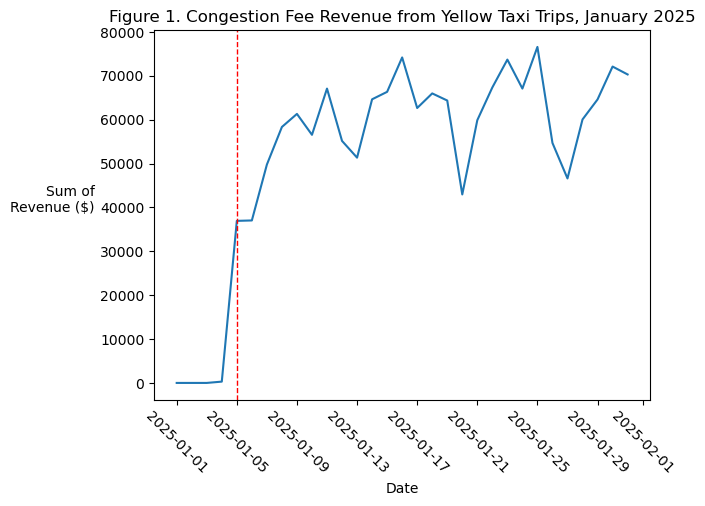

In [29]:
# create line plot of daily congestion fee revenue
plt.plot(analysis1['pickup_date'], analysis1['total_congestion_rev'])
plt.xticks(rotation=-45)
plt.axvline(x=pd.to_datetime('2025-01-05'), color='r', linestyle='--', linewidth=1)
plt.title('Figure 1. Congestion Fee Revenue from Yellow Taxi Trips, January 2025')
plt.xlabel('Date')
plt.ylabel('Sum of\nRevenue ($)', rotation = 'horizontal', ha = 'right')

plt.savefig("C:/Users/jmcca/OneDrive/Documents/Data/Output/sum_of_revenue.svg", bbox_inches='tight')
plt.show()

(array([20089., 20093., 20097., 20101., 20105., 20109., 20113., 20117.,
        20120.]),
 [Text(20089.0, 0, '2025-01-01'),
  Text(20093.0, 0, '2025-01-05'),
  Text(20097.0, 0, '2025-01-09'),
  Text(20101.0, 0, '2025-01-13'),
  Text(20105.0, 0, '2025-01-17'),
  Text(20109.0, 0, '2025-01-21'),
  Text(20113.0, 0, '2025-01-25'),
  Text(20117.0, 0, '2025-01-29'),
  Text(20120.0, 0, '2025-02-01')])

Text(0.5, 1.0, 'Figure 2. Yellow Taxi Trips entering the Congestion Relief Zone, January 2025')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Number\nof Trips')

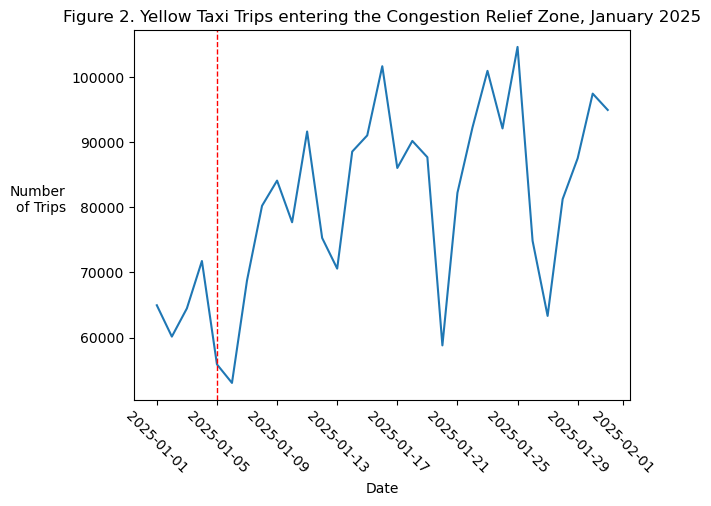

In [30]:
# create line plot of daily number of trips
plt.plot(analysis1['pickup_date'], analysis1['total_trips'])
plt.xticks(rotation=-45)
plt.axvline(x=pd.to_datetime('2025-01-05'), color='r', linestyle='--', linewidth=1)
plt.title('Figure 2. Yellow Taxi Trips entering the Congestion Relief Zone, January 2025')
plt.xlabel('Date')
plt.ylabel('Number\nof Trips', rotation='horizontal', ha='right')

plt.savefig("C:/Users/jmcca/OneDrive/Documents/Data/Output/number_of_trips.svg", bbox_inches='tight')
plt.show()

(array([20089., 20093., 20097., 20101., 20105., 20109., 20113., 20117.,
        20120.]),
 [Text(20089.0, 0, '2025-01-01'),
  Text(20093.0, 0, '2025-01-05'),
  Text(20097.0, 0, '2025-01-09'),
  Text(20101.0, 0, '2025-01-13'),
  Text(20105.0, 0, '2025-01-17'),
  Text(20109.0, 0, '2025-01-21'),
  Text(20113.0, 0, '2025-01-25'),
  Text(20117.0, 0, '2025-01-29'),
  Text(20120.0, 0, '2025-02-01')])

Text(0.5, 1.0, 'Figure 3. Average Yellow Taxi Trip Duration entering the Congestion Relief Zone, January 2025')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Average\nDuration\n(seconds)')

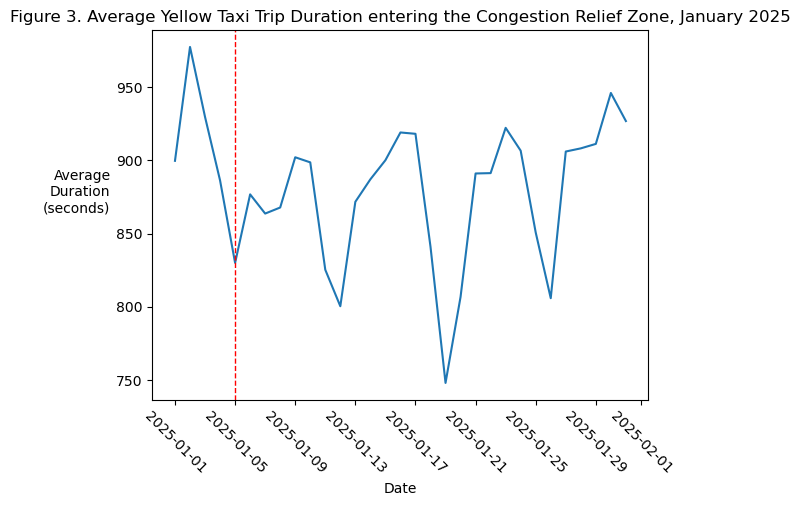

In [31]:
# create line plot of daily average trip duration
plt.plot(analysis1['pickup_date'], analysis1['avg_trip_duration'])
plt.xticks(rotation=-45)
plt.axvline(x=pd.to_datetime('2025-01-05'), color='r', linestyle='--', linewidth=1)
plt.title('Figure 3. Average Yellow Taxi Trip Duration entering the Congestion Relief Zone, January 2025')
plt.xlabel('Date')
plt.ylabel('Average\nDuration\n(seconds)', rotation = 'horizontal', ha = 'right')

plt.savefig("C:/Users/jmcca/OneDrive/Documents/Data/Output/avg_duration.svg", bbox_inches='tight')
plt.show()

# Analysis 2

The goal of this analysis is to assess the spatial distribution of yellow taxi demand across NYC neighborhoods. Specifically, I will look at the average number of daily pickups by neighborhood. 

<Axes: >

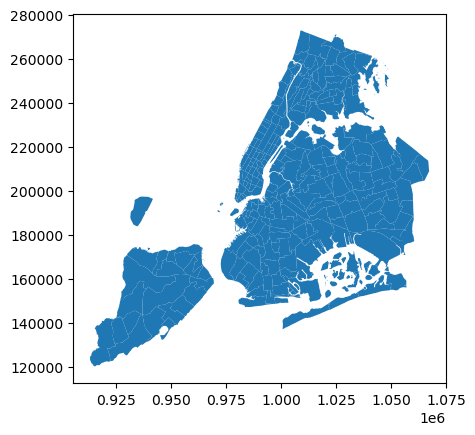

In [32]:
#checking default shapefile plot
nyc_shape.plot()
#looks cool

In [33]:
# sum number of trips on the pick up location - date level
analysis2_pu_step1 = trip_data_duration1.groupby(['PULocationID', 'pickup_date']).agg(number_of_trips = ('trip', 'sum')).reset_index()

# now repeat for dropoff
analysis2_do_step1 = trip_data_duration1.groupby(['DOLocationID', 'pickup_date']).agg(number_of_trips = ('trip', 'sum')).reset_index()

# average number of trips on location level, for both pick up and drop off locations
analysis2_pu = analysis2_pu_step1.groupby('PULocationID').agg(average_number_of_trips = ('number_of_trips', 'mean')).reset_index()
analysis2_do = analysis2_do_step1.groupby('DOLocationID').agg(average_number_of_trips = ('number_of_trips', 'mean')).reset_index()

#check output
analysis2_pu
analysis2_do

,PULocationID,average_number_of_trips
0,1,12.161290
1,2,1.000000
2,3,5.833333
3,4,241.354839
4,5,1.000000
...,...,...
256,261,537.129032
257,262,1600.290323
258,263,2174.483871
259,264,262.612903


,DOLocationID,average_number_of_trips
0,1,221.709677
1,2,1.333333
2,3,10.064516
3,4,484.258065
4,5,1.000000
...,...,...
255,261,532.935484
256,262,1746.709677
257,263,2383.516129
258,264,386.322581


In [34]:
# left join the average number of trips by location to the nyc shape file, both pickup and dropoff
analysis2_merged_pu = pd.merge(nyc_shape, analysis2_pu, left_on = 'OBJECTID', right_on = 'PULocationID', how = 'left')
analysis2_merged_do = pd.merge(nyc_shape, analysis2_do, left_on = 'OBJECTID', right_on = 'DOLocationID', how = 'left')

#check
analysis2_merged_pu
analysis2_merged_do
#noting here that locations 264 and 265 are not actually part of the nyc shapefile and are being dropped as intended

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,average_number_of_trips
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1.0,12.161290
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",2.0,1.000000
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",3.0,5.833333
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4.0,241.354839
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",5.0,1.000000
...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",259.0,9.645161
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",260.0,47.612903
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",261.0,537.129032
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824....",262.0,1600.290323


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,DOLocationID,average_number_of_trips
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1.0,221.709677
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",2.0,1.333333
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",3.0,10.064516
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4.0,484.258065
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",5.0,1.000000
...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",259.0,13.354839
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",260.0,79.483871
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",261.0,532.935484
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824....",262.0,1746.709677


<Axes: >

Text(0.5, 1.0, 'Figure 4. Average Daily Yellow Taxi Pick Ups by Neighborhood, January 2025')

(905464.7390389859, 1075092.878374982, 112485.76061678902, 280480.4146430247)

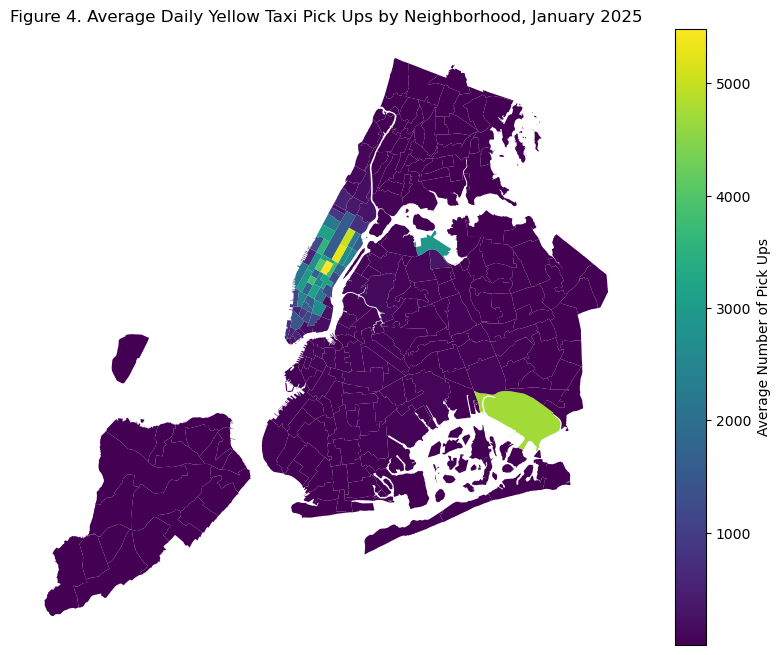

In [35]:
# make choropleth of average daily pick up locations
fig, ax = plt.subplots(figsize=(10, 8))
analysis2_merged_pu.plot(column = 'average_number_of_trips', 
                         cmap = 'viridis', 
                         ax=ax, 
                         legend=True,
                         legend_kwds={'label': 'Average Number of Pick Ups',
                                      'orientation': 'vertical'})
ax.set_title('Figure 4. Average Daily Yellow Taxi Pick Ups by Neighborhood, January 2025')
ax.axis('off') # turn off axis ticks

plt.savefig("C:/Users/jmcca/OneDrive/Documents/Data/Output/neighborhood_pickups.svg", bbox_inches='tight')
plt.show()

<Axes: >

Text(0.5, 1.0, 'Figure 5. Average Daily Yellow Taxi Drop Offs by Neighborhood, January 2025')

(905464.7390389859, 1075092.878374982, 112485.76061678902, 280480.4146430247)

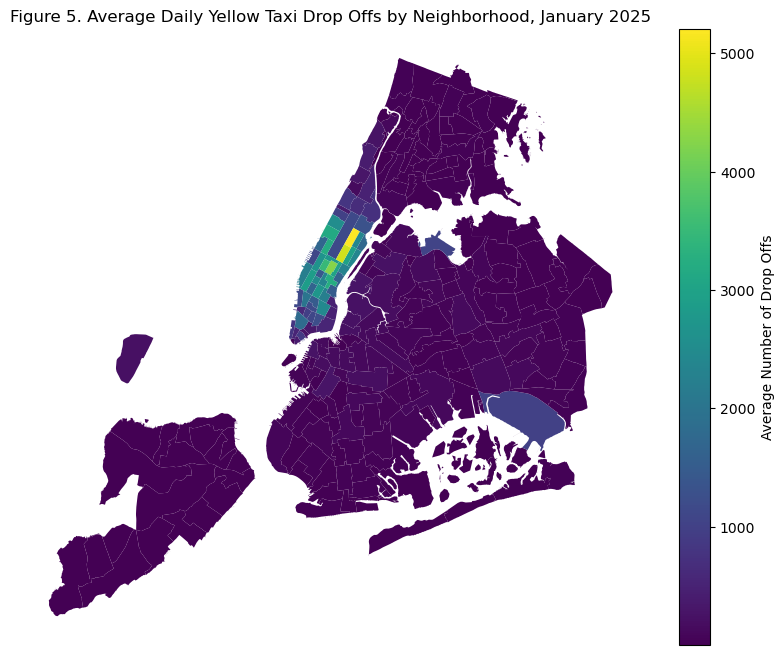

In [36]:
# repeat choropleth for dropoffs
fig, ax = plt.subplots(figsize=(10, 8))
analysis2_merged_do.plot(column = 'average_number_of_trips', 
                         cmap = 'viridis', 
                         ax=ax, 
                         legend=True,
                         legend_kwds={'label': 'Average Number of Drop Offs',
                                      'orientation': 'vertical'})
ax.set_title('Figure 5. Average Daily Yellow Taxi Drop Offs by Neighborhood, January 2025')
ax.axis('off') # turn off axis ticks

plt.savefig("C:/Users/jmcca/OneDrive/Documents/Data/Output/neighborhood_dropoffs.svg", bbox_inches='tight')
plt.show()

In [37]:
# check the 5 highest and lowest average daily pickups and dropoffs
analysis2_merged_pu[analysis2_merged_pu['average_number_of_trips'].notna()].sort_values(by = 'average_number_of_trips')
analysis2_merged_do[analysis2_merged_do['average_number_of_trips'].notna()].sort_values(by = 'average_number_of_trips')

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,average_number_of_trips
83,84,0.233624,0.002074,Eltingville/Annadale/Prince's Bay,84,Staten Island,"POLYGON ((939754.454 131548.91, 939802.804 131...",84.0,1.000000
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",2.0,1.000000
198,199,0.077809,0.000289,Rikers Island,199,Bronx,"POLYGON ((1015023.713 230286.759, 1015093.307 ...",199.0,1.000000
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",5.0,1.000000
186,187,0.126868,0.000421,Port Richmond,187,Staten Island,"MULTIPOLYGON (((946964.115 173161.64, 946977.8...",187.0,1.000000
...,...,...,...,...,...,...,...,...,...
229,230,0.031028,0.000056,Times Sq/Theatre District,230,Manhattan,"POLYGON ((988786.877 214532.094, 988650.277 21...",230.0,4059.000000
131,132,0.245479,0.002038,JFK Airport,132,Queens,"MULTIPOLYGON (((1032791.001 181085.006, 103283...",132.0,4714.032258
235,236,0.044252,0.000103,Upper East Side North,236,Manhattan,"POLYGON ((995940.048 221122.92, 995812.322 220...",236.0,5020.870968
236,237,0.042213,0.000096,Upper East Side South,237,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21...",237.0,5280.741935


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,DOLocationID,average_number_of_trips
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",5.0,1.000000
104,105,0.077425,0.000369,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,"POLYGON ((979605.759 191880.575, 979978.435 19...",105.0,1.000000
203,204,0.101912,0.000641,Rossville/Woodrow,204,Staten Island,"POLYGON ((927766.539 141772.465, 927864.475 14...",204.0,1.100000
110,111,0.059931,0.000209,Green-Wood Cemetery,111,Brooklyn,"POLYGON ((985590.381 179611.82, 986202.162 179...",111.0,1.200000
43,44,0.235689,0.001945,Charleston/Tottenville,44,Staten Island,"POLYGON ((925284.273 142075.259, 924921.951 14...",44.0,1.300000
...,...,...,...,...,...,...,...,...,...
169,170,0.045769,0.000074,Murray Hill,170,Manhattan,"POLYGON ((991999.299 210994.739, 991972.635 21...",170.0,3227.741935
229,230,0.031028,0.000056,Times Sq/Theatre District,230,Manhattan,"POLYGON ((988786.877 214532.094, 988650.277 21...",230.0,3489.580645
160,161,0.035804,0.000072,Midtown Center,161,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",161.0,4234.129032
236,237,0.042213,0.000096,Upper East Side South,237,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21...",237.0,4837.741935


# Analysis 3

For this analysis, I am interested in how distance, rush hour, and Manhattan trips may be associated with yellow taxi trip duration, and will run several OLS models to test my hypotheses. I expect of course expect marginal distances to be associated with higher duration times, but I also think trips during rush hour and trips in Manhattan might affect the coefficient on distance due to congestion. 

In [38]:
trip_data_duration1

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,cbd_congestion_fee,pickup_date,pickup_hour,pickup_weekday,rush_hour,pickup_congestion_zone,dropoff_congestion_zone,congestion_trip,trip,trip_duration
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,...,0.00,2025-01-01,0,Wednesday,0,1,0,1,1,501.0
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,...,0.00,2025-01-01,0,Wednesday,0,0,0,0,1,153.0
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,...,0.00,2025-01-01,0,Wednesday,0,0,0,0,1,117.0
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,...,0.00,2025-01-01,0,Wednesday,0,0,0,0,1,334.0
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,...,0.00,2025-01-01,0,Wednesday,0,0,0,0,1,212.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3475221,2,2025-01-31 23:01:48,2025-01-31 23:16:29,NaN,3.35,NaN,None,79,237,0,...,0.75,2025-01-31,23,Friday,0,1,0,1,1,881.0
3475222,2,2025-01-31 23:50:29,2025-02-01 00:17:27,NaN,8.73,NaN,None,161,116,0,...,0.75,2025-01-31,23,Friday,0,1,0,1,1,1618.0
3475223,2,2025-01-31 23:26:59,2025-01-31 23:43:01,NaN,2.64,NaN,None,144,246,0,...,0.75,2025-01-31,23,Friday,0,1,1,1,1,962.0
3475224,2,2025-01-31 23:14:34,2025-01-31 23:34:52,NaN,3.16,NaN,None,142,107,0,...,0.75,2025-01-31,23,Friday,0,0,1,1,1,1218.0


In [39]:
# get location id df ready to merge in for borough analysis
location_ids_merge = location_ids[['LocationID', 'Borough']].copy()
location_ids_merge

,LocationID,Borough
0,1,EWR
1,2,Queens
2,3,Bronx
3,4,Manhattan
4,5,Staten Island
...,...,...
260,261,Manhattan
261,262,Manhattan
262,263,Manhattan
263,264,Unknown


In [40]:
#merge in borough of trip pick up
analysis3_step1 = pd.merge(trip_data_duration1, 
                           location_ids_merge, 
                           left_on = 'PULocationID',
                           right_on = 'LocationID',
                           how = 'left').rename(columns={'Borough': 'PUBorough',
                                                        'LocationID': 'PULocationID'})
# now merge in borough of trip drop off
analysis3_step2 = pd.merge(analysis3_step1, 
                           location_ids_merge, 
                           left_on = 'DOLocationID',
                           right_on = 'LocationID',
                           how = 'left').rename(columns={'Borough': 'DOBorough',
                                                        'LocationID': 'DOLocationID'})

# now create indicator of trip pickup or dropoff in Manhattan
analysis3_step3 = analysis3_step2.assign(manhattan_trip = np.where((analysis3_step2['PUBorough'] == 'Manhattan') |
                                                                   (analysis3_step2['DOBorough'] == 'Manhattan'),
                                                                   1, 0))

analysis3_step3['manhattan_trip'].value_counts()

manhattan_trip
1    3272338
0     202866
Name: count, dtype: int64

In [41]:
analysis3_step3[['trip_duration', 'trip_distance', 'rush_hour', 'manhattan_trip']].describe()

,trip_duration,trip_distance,rush_hour,manhattan_trip
count,3.471139e+06,3.383778e+06,3.475204e+06,3.475204e+06
mean,8.744060e+02,3.171137e+00,2.609723e-01,9.416247e-01
std,6.719945e+02,4.101307e+00,4.391649e-01,2.344517e-01
min,1.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00
25%,4.370000e+02,1.010000e+00,0.000000e+00,1.000000e+00
50%,7.020000e+02,1.700000e+00,0.000000e+00,1.000000e+00
75%,1.100000e+03,3.180000e+00,1.000000e+00,1.000000e+00
max,7.198000e+03,5.000000e+01,1.000000e+00,1.000000e+00


In [42]:
# create analysis3 df, where all relevant columns exist
analysis3 = analysis3_step3.dropna(subset=['trip_duration', 'trip_distance', 'rush_hour', 'manhattan_trip'])

analysis3[['trip_duration', 'trip_distance', 'rush_hour', 'manhattan_trip']].isna().sum()
#no NAs, good

trip_duration     0
trip_distance     0
rush_hour         0
manhattan_trip    0
dtype: int64

In [43]:
# first run a simple model, regressing trip_duration on trip_distance
model1 = sm.OLS(analysis3['trip_duration'],
                sm.add_constant(analysis3['trip_distance']))

results1 = model1.fit(cov_type='HC1') # run model with heteroskedasticity robust covariance

print(results1.summary())

print('Parameters:', results1.params)

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                 1.216e+06
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        14:02:50   Log-Likelihood:            -2.5041e+07
No. Observations:             3380531   AIC:                         5.008e+07
Df Residuals:                 3380529   BIC:                         5.008e+07
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           462.3401      0.319   1451.460

In [44]:
# second add rush hour
model2 = sm.OLS(analysis3['trip_duration'],
                sm.add_constant(analysis3[['trip_distance', 'rush_hour']]))

results2 = model2.fit(cov_type='HC1')

print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                 6.259e+05
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        14:02:52   Log-Likelihood:            -2.5022e+07
No. Observations:             3380531   AIC:                         5.004e+07
Df Residuals:                 3380528   BIC:                         5.004e+07
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           436.3673      0.345   1264.623

In [45]:
# next add in manhattan_trip indicator to model
model3 = sm.OLS(analysis3['trip_duration'],
                sm.add_constant(analysis3[['trip_distance', 'rush_hour', 'manhattan_trip']]))

results3 = model3.fit(cov_type='HC1')

print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                 4.215e+05
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        14:02:54   Log-Likelihood:            -2.5019e+07
No. Observations:             3380531   AIC:                         5.004e+07
Df Residuals:                 3380527   BIC:                         5.004e+07
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            363.6443      1.772    205.

In [46]:
# function to put OLS model results into a table
def lm_output(model):
    output_list = list() # list of tables to output

    #first table of output - overall model parameters
    overall_summary = pd.DataFrame({
        'adj_r_squared': [model.rsquared_adj],
        'f_stat': [model.fvalue],
        'f_p_value': [model.f_pvalue],
        'df_model': [model.df_model],
        'df_resid': [model.df_resid],
        'cov_type': [model.cov_type]})

    #second table of output - coefficients
    coef_summary = pd.DataFrame({
        'coef': model.params,
        'std_err': model.bse,
        'p_value': model.pvalues})

    #append tables to list
    output_list.append(overall_summary)
    output_list.append(coef_summary)

    # return list of two tables
    return output_list

In [47]:
# table model 3 results
model3_output = lm_output(results3)

model3_output1 = model3_output[0]
model3_output2 = model3_output[1]

In [48]:
# lastly, run model with interaction terms
model4 = smf.ols('trip_duration ~ trip_distance + rush_hour + manhattan_trip + rush_hour * trip_distance + manhattan_trip * trip_distance', data=analysis3).fit(cov_type='HC1')
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                 3.144e+05
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        14:02:59   Log-Likelihood:            -2.4947e+07
No. Observations:             3380531   AIC:                         4.989e+07
Df Residuals:                 3380525   BIC:                         4.989e+07
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [49]:
# table interaction model
model4_output = lm_output(model4)

model4_output1 = model4_output[0]
model4_output2 = model4_output[1]

In [50]:
# write model output to excel
with pd.ExcelWriter('C:/Users/jmcca/OneDrive/Documents/Data/Output/TLC_model_output.xlsx', mode = 'w') as writer:
    # Write to separate sheets
    model3_output1.to_excel(writer, sheet_name='Sheet1', startrow=0, index=False)
    model3_output2.to_excel(writer, sheet_name='Sheet1', startrow=3, index=True)

    model4_output1.to_excel(writer, sheet_name='Sheet2', startrow=0, index=False)
    model4_output2.to_excel(writer, sheet_name='Sheet2', startrow=3, index=True)

In [51]:
# thanks for reading to the end :)